In [1]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
mnet = MobileNetV2(input_shape=(224, 224, 3), include_top=False, alpha=1)  # para controlar o tamanho da rede, pode mudar o parâmetro alpha
mnet

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

dataset, metadata = tfds.load('beans', as_supervised=True, with_info=True)
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['angular_leaf_spot', 'bean_rust', 'healthy']


In [3]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

def resize(images, labels):
    images = tf.image.resize(images, size=(224, 224))
    labels = tf.one_hot(labels, len(class_names))

    return images, labels

def transform_images(images, labels):
    images, labels = resize(images, labels)
    images, labels = normalize(images, labels)

    return images, labels

train_dataset =  train_dataset.map(transform_images)
validation_dataset =  validation_dataset.map(transform_images)
test_dataset =  test_dataset.map(transform_images)

train_dataset =  train_dataset.cache()
validation_dataset =  validation_dataset.cache()
test_dataset =  test_dataset.cache()

In [4]:
for image, labels in train_dataset.take(1):
    break
pred = mnet(tf.expand_dims(image, 0))
pred.shape

TensorShape([1, 7, 7, 1280])

In [5]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
mnet.trainable = False
gap = GlobalAveragePooling2D()
dropout = Dropout(rate=0.25)
fc1 = Dense(units=len(class_names), activation=tf.nn.softmax)
layers =[
    mnet,  # feature extractor
    gap,  # no lugar do flatten, utilizamos GAP
    dropout,
    fc1,
]
model = tf.keras.models.Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [6]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
import numpy as np

BATCH_SIZE = 32

num_train_examples = metadata.splits['train'].num_examples
num_validation_examples = metadata.splits['validation'].num_examples
num_test_examples = metadata.splits['test'].num_examples

train_dataset = train_dataset \
    .cache() \
    .repeat() \
    .shuffle(num_train_examples) \
    .batch(BATCH_SIZE)

validation_dataset = validation_dataset \
    .cache() \
    .repeat() \
    .shuffle(num_validation_examples) \
    .batch(BATCH_SIZE)

Epoch 1/10
33/33 [==============================] - 48s 1s/step - loss: 0.7971 - accuracy: 0.6562 - val_loss: 0.5435 - val_accuracy: 0.7688
Epoch 2/10
33/33 [==============================] - 38s 1s/step - loss: 0.5297 - accuracy: 0.7746 - val_loss: 0.3683 - val_accuracy: 0.8250
Epoch 3/10
33/33 [==============================] - 37s 1s/step - loss: 0.4134 - accuracy: 0.8295 - val_loss: 0.3774 - val_accuracy: 0.8500
Epoch 4/10
33/33 [==============================] - 33s 986ms/step - loss: 0.3506 - accuracy: 0.8570 - val_loss: 0.2919 - val_accuracy: 0.9062
Epoch 5/10
33/33 [==============================] - 32s 978ms/step - loss: 0.3234 - accuracy: 0.8911 - val_loss: 0.2671 - val_accuracy: 0.9250
Epoch 6/10
33/33 [==============================] - 36s 1s/step - loss: 0.2893 - accuracy: 0.8883 - val_loss: 0.2151 - val_accuracy: 0.9250
Epoch 7/10
33/33 [==============================] - 32s 960ms/step - loss: 0.2503 - accuracy: 0.9025 - val_loss: 0.2888 - val_accuracy: 0.9125
Epoch 8/10


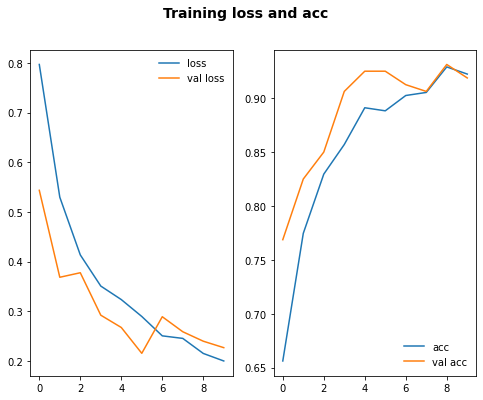

In [8]:
history = model.fit(
    train_dataset, epochs=10,
    steps_per_epoch=np.ceil(num_train_examples/BATCH_SIZE),
    validation_data=validation_dataset,
    validation_steps=np.ceil(num_validation_examples/BATCH_SIZE),
    workers=-1,
)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='val loss')
ax[0].legend(frameon=False)
ax[1].plot(history.history['accuracy'], label='acc')
ax[1].plot(history.history['val_accuracy'], label='val acc')
ax[1].legend(frameon=False)
fig.suptitle("Training loss and acc", fontweight='bold', fontsize=14);

In [9]:
test_dataset = test_dataset \
    .cache() \
    .batch(BATCH_SIZE)
model.evaluate(test_dataset)

4/4 [==============================] - 4s 945ms/step - loss: 0.2716 - accuracy: 0.9062


[0.2716454565525055, 0.90625]